In [102]:
import torch
from torch import nn
from torch.utils.data import DataLoader
IMAGE_SIZE = 64
IMAGES_PER_CLASS = 2000

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [103]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
try:
    API_KEY = os.environ["REBRICKABLE_API_KEY"]
except:
    print('Please add your Rebrickable API Key to the project as instructed in the README.')

In [205]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import tqdm
import requests as r

class CustomImageDataset(Dataset):
    def __init__(self, dataset_path):

        # Init output data
        x_data = []
        y_data = []
        labels = []

        encoding = { 'woohoo!': -1 }
        
        # For each class folder
        for label in os.listdir(dataset_path)[:5]:

            # Initialize variables to retrieve and store images
            curr_path = dataset_path + "/" + label

            # For each image
            for filename in tqdm.tqdm(os.listdir(curr_path)[:IMAGES_PER_CLASS]):

                # Store image in tensor representation
                image_path = curr_path + "/" + filename
                image_tensor = read_image(image_path)

                # Add tensor to data dictionary
                x_data.append(image_tensor / 255.0)
                if label not in encoding:
                    encoding[label] = max(list(encoding.values())) + 1
                y_data.append(encoding[label])
                labels.append(label)

        self.x_data = x_data
        self.y_data = y_data
        self.labels = set(labels)

        rebrickable_query = 'https://rebrickable.com/api/v3/lego/parts/?key=' + API_KEY + '&part_nums='
        for label in self.labels:
            rebrickable_query += label + ','

        self.brick_info = {}
        response = r.get(rebrickable_query).json()
        for entry in response['results']:
            self.brick_info[entry['part_num']] = entry

        self.brick_info = pd.DataFrame(self.brick_info).T

    def __len__(self):
        assert len(self.x_data) == len(self.y_data)
        return len(self.x_data)

    def __getitem__(self, idx):
        return (self.x_data[idx], self.y_data[idx])

In [207]:
dataset = CustomImageDataset('dataset')

100%|██████████| 2000/2000 [00:01<00:00, 1187.15it/s]


In [208]:
dataset.brick_info

,part_num,name,part_cat_id,part_url,part_img_url,external_ids,print_of
10247,10247,Plate Special 2 x 2 with 1 Pin Hole [Complete ...,9,https://rebrickable.com/parts/10247/plate-spec...,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['10247'], 'BrickOwl': ['268558'...",None
11090,11090,Bar Holder with Clip,32,https://rebrickable.com/parts/11090/bar-holder...,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['11090'], 'BrickOwl': ['112838'...",None
11211,11211,Brick Special 1 x 2 with 2 Studs on 1 Side,5,https://rebrickable.com/parts/11211/brick-spec...,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['11211'], 'BrickOwl': ['929279'...",None
11212,11212,Plate 3 x 3,14,https://rebrickable.com/parts/11212/plate-3-x-3/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['11212'], 'BrickOwl': ['855115'...",None
11214,11214,Technic Axle Pin 3L with Friction Ridges Lengt...,53,https://rebrickable.com/parts/11214/technic-ax...,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['11214'], 'BrickOwl': ['102238'...",None


In [241]:
from torch.utils.data import DataLoader

# train_data, test_data = torch.utils.data.random_split(dataset, [320000, 80000])
train_data, test_data = torch.utils.data.random_split(dataset, [8000, 2000])
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=20, shuffle=True)

Feature batch shape: torch.Size([20, 3, 64, 64])


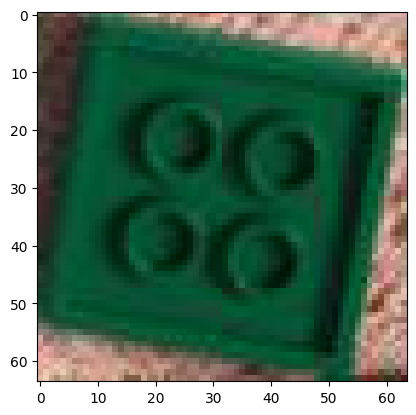

Label: 3


In [242]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [271]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 20, 10)
        self.conv2 = nn.Conv2d(20, 64, 10)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64, 128)  # 5*5 from image dimension
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (5, 5))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cpu()
print(net.to(torch.device('cpu')))

Net(
  (conv1): Conv2d(3, 20, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(20, 64, kernel_size=(10, 10), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


In [272]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [277]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

[1,   100] loss: 11.988
[1,   200] loss: 11.584
[1,   300] loss: 11.315
[1,   400] loss: 10.832
[2,   100] loss: 10.772
[2,   200] loss: 10.218
[2,   300] loss: 9.937
[2,   400] loss: 9.914
[3,   100] loss: 9.397
[3,   200] loss: 9.361
[3,   300] loss: 8.998
[3,   400] loss: 8.812
[4,   100] loss: 8.720
[4,   200] loss: 8.339
[4,   300] loss: 8.197
[4,   400] loss: 7.593
[5,   100] loss: 7.529
[5,   200] loss: 7.348
[5,   300] loss: 7.218
[5,   400] loss: 7.071
[6,   100] loss: 6.269
[6,   200] loss: 6.310
[6,   300] loss: 6.609
[6,   400] loss: 6.433
[7,   100] loss: 5.854
[7,   200] loss: 5.965
[7,   300] loss: 5.513
[7,   400] loss: 5.358
[8,   100] loss: 5.137
[8,   200] loss: 5.118
[8,   300] loss: 4.595
[8,   400] loss: 4.834
[9,   100] loss: 4.288
[9,   200] loss: 4.575
[9,   300] loss: 4.412
[9,   400] loss: 3.947
[10,   100] loss: 3.677
[10,   200] loss: 3.383
[10,   300] loss: 3.599
[10,   400] loss: 4.301


In [278]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(correct)
print(total)